In [47]:
import os
import tweepy
from tweepy import Stream

import netrc

from unidecode import unidecode
import re

from tweepy import StreamListener

%matplotlib inline

from pprint import pprint
import pandas as pd

import random
from scipy.stats import beta as beta_distribution
import numpy as np

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim  # don't skip this

from gensim.models.ldamodel import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from textblob import Word
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.simplefilter('ignore' )

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
auth = netrc.netrc()
ckey,_,csecret=auth.authenticators('tweet_api')
atoken,_,asecret=auth.authenticators('tweet_secret')

[BoundingBox](https://boundingbox.klokantech.com/)
CSV RAW

In [3]:
LIMA_GEO_LOCATION_BOUNDING_BOX = [-77.1785277831,-12.1531578397,-76.8967618806,-11.9288928156]
auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)

In [4]:
class FiniteStreamListener(StreamListener):
    
    def __init__(self, number_of_tweets):
        self.number_of_tweets = number_of_tweets
        self.tweets = []
        super(FiniteStreamListener,self).__init__()
        
    def on_status(self, status):
        if len(self.tweets) < self.number_of_tweets:
            self.tweets.append({'date':status.created_at,
                                'text':status.text,
                                'location':status._json['place']['name'],
                                'followers':status._json['user']['followers_count']})
        else:
            return False
        

In [5]:
NUMBER_OF_TWEETS = 1000
finite_stream_listener = FiniteStreamListener(number_of_tweets=NUMBER_OF_TWEETS)
streaming_api = Stream(auth=auth, listener=finite_stream_listener,timeout=60)

In [6]:
EMOTICONS = ">:] :-) :) :o) :] :3 :c) :> =] 8) =) :} :^) "
EMOTICONS = EMOTICONS.strip().split(' ')
# streaming_api.filter(track=EMOTICONS,locations=LIMA_GEO_LOCATION_BOUNDING_BOX)
streaming_api.filter(locations=LIMA_GEO_LOCATION_BOUNDING_BOX,async=True)

<input>:4: DeprecationWarning: 'async' and 'await' will become reserved keywords in Python 3.7
<input>:4: DeprecationWarning: 'async' and 'await' will become reserved keywords in Python 3.7
<input>:4: DeprecationWarning: 'async' and 'await' will become reserved keywords in Python 3.7
<ipython-input-6-34255b71a6df>:4: DeprecationWarning: 'async' and 'await' will become reserved keywords in Python 3.7
  streaming_api.filter(locations=LIMA_GEO_LOCATION_BOUNDING_BOX,async=True)


In [7]:
def make_lowercase(tweet):
    return tweet.lower()

def remove_diacritics(tweet):
    return unidecode(tweet)

def remove_non_alpha_characters(tweet):
    return ''.join(character for character in tweet if character.isalpha() or character == ' ')

def remove_web_site(tweet):
    return re.sub(r'http\w+', '', tweet)#, flags=re.MULTILINE)

In [924]:
print(len(finite_stream_listener.tweets))

942


In [925]:
tweets_df = pd.DataFrame.from_dict(finite_stream_listener.tweets)
tweets_df.rename(columns={'text':'Tweets'},inplace=True)

In [926]:
tweets_df['word_count'] = tweets_df['Tweets'].apply(lambda x: len(str(x).split(" ")))
tweets_df['char_count'] = tweets_df['Tweets'].str.len()

def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

tweets_df['avg_word'] = tweets_df['Tweets'].apply(lambda x: avg_word(x))
tweets_df['hastags'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets_df['numerics'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [927]:
cleaned_tweets = list(tweets_df['Tweets'])
for cleaning_function in \
    [make_lowercase, 
#      remove_diacritics,
     remove_non_alpha_characters,
     remove_web_site]:
    cleaned_tweets = [cleaning_function(tweet) for tweet in cleaned_tweets]

In [928]:
random.sample(cleaned_tweets,5)

['segundo día consecutivo que veo este vehículo donando alimentos a los refugiados que esperan afuera de migraciones ',
 'bonattidi no te das cuenta que la policía no kiere cuidar para tirarse esa plata de los operativos',
 'hay  palabras que te abren las puertas en esta vida             jale y empuje',
 'wynnsummoner por los esteroides anabólicos más bien ',
 'el papi ya podrá visitar la tiendita de mi papicha mariogu es un buen daaaaaaaato']

In [929]:
KEYWORD='lima'
number_of_occurences = sum(KEYWORD in tweet for tweet in cleaned_tweets)
print('Nuestra palabra clave aparece: {} veces'.format(number_of_occurences))
print('Nuestra palabra clave apareció en: {}% de los tweets'.format(100 * number_of_occurences/NUMBER_OF_TWEETS))

Nuestra palabra clave aparece: 73 veces
Nuestra palabra clave apareció en: 7.3% de los tweets


In [930]:
pprint([tweet for tweet in cleaned_tweets if KEYWORD in tweet][:5])

['im at tacna  emancipación in lima  ',
 'im at ministerio de la mujer y poblaciones vulnerables in cercado de lima '
 'lima ',
 'navidad en el cielo y la tierra   mibanco in surquillo lima ',
 'el partido en moyobamba hace rato que se terminó lo gana bien alianza lima '
 'tendrían que suceder dos milagros de e ',
 'campaña panetones  ogilvy amp mather  ogilvype in lima ']


In [931]:
indices_of_tweets_containing_keyword=[index for index, tweet in enumerate(cleaned_tweets) if KEYWORD in tweet]
print('index de los 10 tweets:%s'%(indices_of_tweets_containing_keyword))

index de los 10 tweets:[9, 13, 24, 35, 54, 86, 97, 100, 105, 111, 112, 121, 148, 167, 176, 219, 227, 243, 246, 247, 273, 278, 280, 286, 304, 320, 322, 330, 361, 365, 376, 382, 385, 396, 410, 418, 423, 440, 450, 484, 486, 495, 499, 501, 507, 529, 535, 544, 608, 636, 637, 638, 645, 663, 670, 681, 686, 705, 744, 754, 761, 765, 789, 799, 846, 863, 869, 879, 890, 909, 925, 933, 941]


In [932]:
distances_between_indices_of_tweets_containing_keyword = [
    second_index - first_index for first_index, second_index in \
        zip(indices_of_tweets_containing_keyword[:-1], indices_of_tweets_containing_keyword[1:])
]

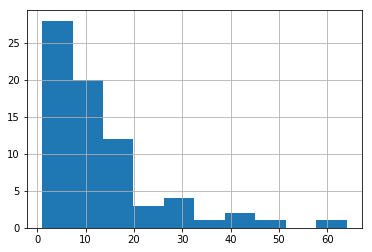

In [933]:
pd.Series(distances_between_indices_of_tweets_containing_keyword).hist()
plt.savefig('lima_tweets_hist.png')

In [934]:
alpha = 1 + number_of_occurences
beta = 1 + (NUMBER_OF_TWEETS - number_of_occurences)

x_values = np.linspace(0, 1, 1002)[1:-1]
pdf_y_values = beta_distribution(alpha, beta).pdf(x_values)
cdf_y_values = np.cumsum(pdf_y_values) / np.sum(pdf_y_values)

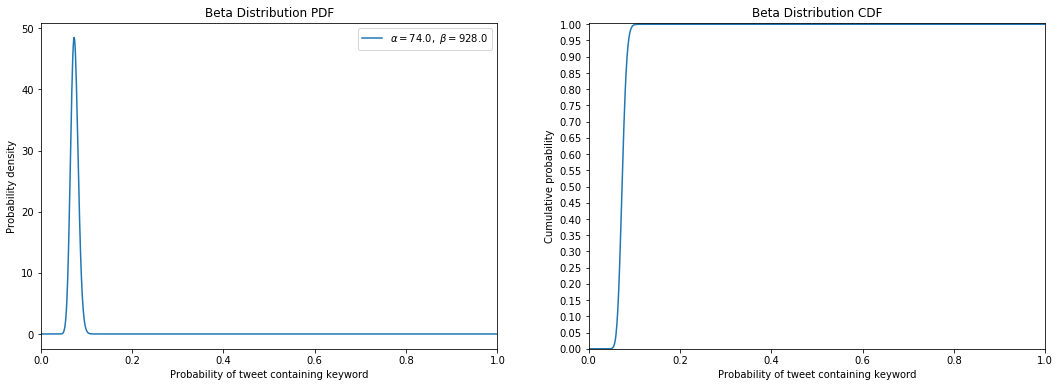

In [935]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(x_values, pdf_y_values, label=(r'$\alpha=%.1f,\ \beta=%.1f$' % (alpha, beta)))

plt.xlim(0, 1)
plt.xlabel('Probability of tweet containing keyword')
plt.ylabel('Probability density')
plt.title('Beta Distribution PDF')
plt.legend(loc=1)

plt.subplot(122)
plt.plot(x_values, cdf_y_values)
plt.xlim(0, 1)
plt.ylim(0, 1.005)
plt.yticks(np.linspace(0, 1, 21))
plt.xlabel('Probability of tweet containing keyword')
plt.ylabel('Cumulative probability')
plt.title('Beta Distribution CDF')
plt.savefig('Beta Distribution CDF.png');

In [936]:
ix = [n for n,b in enumerate((cdf_y_values>.5)&(cdf_y_values<.95)) if b]

In [937]:
range_ =cdf_y_values[ix]

In [938]:
a=np.c_[x_values[ix],cdf_y_values[ix]]
max_ix,_ = np.unravel_index(a.argmax(), a.shape)
min_ix,_ = np.unravel_index(a.argmin(), a.shape)
fifth_percentile, ninety_fifth_percentile = x_values[max_ix],x_values[min_ix]

In [939]:
print('Con 90% de certeza digamos que la verdadera probabilidad se encuentra entre: {} y {}'.format(
    round(fifth_percentile, 10), round(ninety_fifth_percentile, 10)))

Con 90% de certeza digamos que la verdadera probabilidad se encuentra entre: 0.013986014 y 0.000999001


In [940]:
def compute_total_probability_that_probability_less_than_p(p):
    return max(cumulative_prob for cumulative_prob, x_value in zip(cdf_y_values, x_values) if x_value < p)

print('La probabilidad que la verdadera probabilidad es > .1 es: {}'.format(
    1 - compute_total_probability_that_probability_less_than_p(.1)))

La probabilidad que la verdadera probabilidad es > .1 es: 0.0015664324813199348


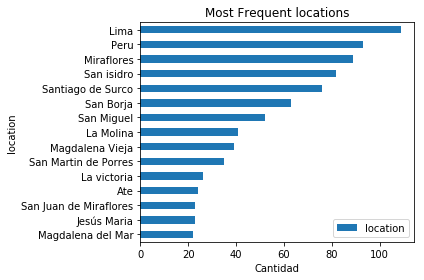

In [941]:
tweets_df.groupby('location').agg({'location':len}).sort_values('location').iloc[-15:].plot(kind='barh')
plt.title('Most Frequent locations')
plt.xlabel('Cantidad')
plt.tight_layout()
plt.savefig('most Frequent locations.png');

In [942]:
tweets_df.to_csv('lima_tweets.csv',index=None)

In [960]:
tweets_df = pd.read_csv('lima_tweets.csv')

In [1006]:
doc_complete = tweets_df.Tweets.values
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]   
tweets_df.dropna(inplace=True)

In [1007]:
tweets_df['Tweets_clean'] = pd.Series(doc_clean).apply(lambda x:' '.join(x))
tweets_df['word_count'] = tweets_df['Tweets_clean'].apply(lambda x: len(str(x).split(" ")))
tweets_df['char_count'] = tweets_df['Tweets_clean'].str.len()

In [1036]:
def avg_word(sentence):
    words = sentence.split()
    if len(words)==0:
        return 0
    return (sum(len(word) for word in words)/len(words))

tweets_df['avg_word'] = tweets_df['Tweets_clean'].apply(lambda x: avg_word(x))
tweets_df['hastags'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets_df['numerics'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets_df.head()

,date,followers,location,Tweets,word_count,char_count,avg_word,hastags,numerics,Tweets_clean,ACTIONS,NOUNS
0,2018-09-21 22:03:22,279,Magdalena Vieja,Cachito si la vas a seguir perdiendo al menos haz el esfuerzo de recuperarla,8,58,6.375000,0,0,cachito va seguir perdiendo menos haz esfuerzo recuperarla,"perdiendo, haz",esfuerzo
1,2018-09-21 22:03:27,2664,Lima,obrigada meu Deus pela terceira viagem internacional em menos de um ano! Há uns dois anos atrás eu não acharia isso ...,13,106,7.230769,0,0,edusobrino claro facilidad q transita comercio preocupante sucede xq jugamos volante c… httpstcotampwuzwlx,leao,veces
2,2018-09-21 22:03:33,74,Independencia,"@Edu_Sobrino Claro la facilidad con la q transita comercio es preocupante, y eso sucede xq jugamos sin volante de C…...",3,18,5.333333,0,0,cuantas veces leao,"colocan, sé",leninguari
3,2018-09-21 22:03:35,497,San isidro,Cuantas veces Leao,12,96,7.083333,0,0,leninguari alexdar228 bueno sé sé colocan excusa contratarte consabido ptp p… httpstcofs7kqpnbp7,"matar, httpstcogoztpltwtz, anulado, engañar",inmunidad
4,2018-09-21 22:03:50,42266,Peru,@Leninguari @AlexDar228 Bueno yo no sé. Lo que si sé es que colocan como excusa para contratarte el consabido PTP p…...,10,89,8.000000,0,0,inmunidad debe anulado inmunidad robar matar engañar inmunidad jueces… httpstcogoztpltwtz,"informó, iniciar",atención


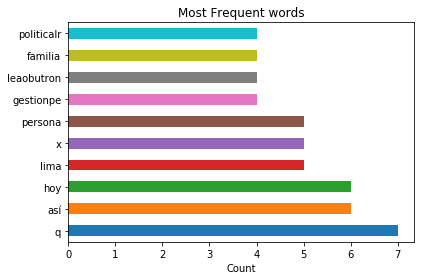

In [1037]:
freq = pd.Series(' '.join(tweets_df['Tweets_clean']).split()).value_counts()[:10]
freq.plot(kind='barh')
plt.title('Most Frequent words')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig('most Frequent words.png');

In [1038]:
pprint(tweets_df['Tweets_clean'][:2])

0                                                    cachito va seguir perdiendo menos haz esfuerzo recuperarla
1    edusobrino claro facilidad q transita comercio preocupante sucede xq jugamos volante c… httpstcotampwuzwlx
Name: Tweets_clean, dtype: object


In [1039]:
dictionary = corpora.Dictionary(tweets_df['Tweets_clean'].apply(lambda x:x.split()))

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [1040]:
pprint(doc_term_matrix[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(3, 1)]]


In [1041]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [1042]:
from pprint import pprint
pprint(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, '0.023*"lima" + 0.014*"peru" + 0.011*"mejor"'),
 (1, '0.016*"quiero" + 0.014*"bien" + 0.013*"phillbutters"'),
 (2, '0.011*"ver" + 0.009*"perú" + 0.009*"no"')]


In [1043]:
# from gensim.test.utils import datapath
# fname = datapath("lda_lima_tweet_model")
ldamodel.save("lda_lima_tweet_model")

In [1044]:
from gensim.models.ldamodel import LdaModel
ldamodel = LdaModel.load("lda_lima_tweet_model")

In [1045]:
doc_lda = ldamodel[doc_term_matrix]

In [1046]:
print('Perplexity: ', ldamodel.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better

Perplexity:  -7.264388394159867


In [1047]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.133751 -0.023550       1        1  37.888680
2      0.089134 -0.094356       2        1  32.139812
0      0.044617  0.117906       3        1  29.971508, topic_info=     Category       Freq            Term      Total  loglift  logprob
term                                                                 
281   Default  15.000000            lima  15.000000  30.0000  30.0000
219   Default  14.000000          quiero  14.000000  29.0000  29.0000
638   Default   9.000000            peru   9.000000  28.0000  28.0000
591   Default  12.000000            bien  12.000000  27.0000  27.0000
549   Default  10.000000       exitosape  10.000000  26.0000  26.0000
842   Default   8.000000             ver   8.000000  25.0000  25.0000
348   Default   7.000000           mejor   7.000000  24.0000  24.0000
69    Default   8.000000            solo   8.000000  23.0000  23.0000
287   Default   6.000000              no   6.000000  22.0000  22.0000
534   Default   8.000000            vida   8.000000  21.0000  21.0000
113   Default  13.000000    phillbutters  13.000000  20.0000  20.0000
159   Default  15.000000             hoy  15.000000  19.0000  19.0000
312   Default  14.000000           ahora  14.000000  18.0000  18.0000
280   Default  11.000000              in  11.000000  17.0000  17.0000
108   Default   5.000000           buena   5.000000  16.0000  16.0000
670   Default  10.000000            perú  10.000000  15.0000  15.0000
71    Default   6.000000           tener   6.000000  14.0000  14.0000
804   Default   6.000000              at   6.000000  13.0000  13.0000
230   Default   6.000000  alvarezrodrich   6.000000  12.0000  12.0000
36    Default   5.000000            debe   5.000000  11.0000  11.0000
984   Default   7.000000            creo   7.000000  10.0000  10.0000
226   Default   6.000000            pasa   6.000000   9.0000   9.0000
131   Default   4.000000           hacer   4.000000   8.0000   8.0000
290   Default   4.000000              s…   4.000000   7.0000   7.0000
626   Default   4.000000         trabajo   4.000000   6.0000   6.0000
34    Default   4.000000              sé   4.000000   5.0000   5.0000
806   Default   5.000000              im   5.000000   4.0000   4.0000
567   Default   5.000000         familia   5.000000   3.0000   3.0000
16    Default  10.000000               q  10.000000   2.0000   2.0000
1063  Default   3.000000            sido   3.000000   1.0000   1.0000
...       ...        ...             ...        ...      ...      ...
703    Topic3   2.177251          piensa   2.628721   1.0165  -5.7326
874    Topic3   2.171427               u   2.628857   1.0138  -5.7353
923    Topic3   2.171492         público   2.628951   1.0138  -5.7352
497    Topic3   2.168720           nueva   2.629062   1.0124  -5.7365
184    Topic3   2.152184           saben   2.629706   1.0045  -5.7442
36     Topic3   4.758492            debe   5.914787   0.9874  -4.9507
248    Topic3   2.060205             aun   2.633305   0.9595  -5.7878
275    Topic3   1.525110           borja   1.974967   0.9464  -6.0886
911    Topic3   1.524943            this   1.974972   0.9463  -6.0887
537    Topic3   1.524941           dicen   1.974972   0.9463  -6.0887
765    Topic3   1.524938          sunset   1.974972   0.9463  -6.0887
750    Topic3   1.524932          sector   1.974972   0.9463  -6.0887
180    Topic3   1.524930      josemartsn   1.974972   0.9463  -6.0887
1084   Topic3   1.524839          travel   1.974975   0.9463  -6.0888
1083   Topic3   1.524839             sun   1.974975   0.9463  -6.0888
266    Topic3   2.849175               3   3.960936   0.8755  -5.4636
367    Topic3   3.623593          mañana   5.280283   0.8284  -5.2232
280    Topic3   6.704696              in  11.281994   0.6845  -4.6078
687    Topic3   2.739532              do   3.954442   0.8379  -5.5029
58     Topic3   3.038475              of   4.61

In [1048]:
import spacy
nlp = spacy.load('es')

In [1049]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc_ = nlp(sent)
        texts_out.append(list(set([str(c.head) for c in doc_ if c.head.tag_.startswith(tuple(allowed_postags))])))
    return texts_out

lemmatization(tweets_df['Tweets_clean'][:5],['VERB'])

[['perdiendo', 'haz'],
 ['sucede'],
 ['leao'],
 ['colocan', 'sé'],
 ['matar', 'httpstcogoztpltwtz', 'anulado', 'engañar']]

In [1050]:
def join_comma(row_list):
    if row_list == []:
        return np.NaN
    else:
        return ', '.join(row_list)

tweets_df['ACTIONS']=pd.Series(lemmatization(tweets_df['Tweets_clean'],['VERB'])).apply(join_comma)
tweets_df['NOUNS']=pd.Series(lemmatization(tweets_df['Tweets_clean'],['NOUN'])).apply(join_comma)

In [1051]:
tweets_df[['Tweets_clean','NOUNS','ACTIONS']].head()

,Tweets_clean,NOUNS,ACTIONS
0,cachito va seguir perdiendo menos haz esfuerzo recuperarla,esfuerzo,"perdiendo, haz"
1,edusobrino claro facilidad q transita comercio preocupante sucede xq jugamos volante c… httpstcotampwuzwlx,"transita, jugamos, facilidad",sucede
2,cuantas veces leao,veces,leao
3,leninguari alexdar228 bueno sé sé colocan excusa contratarte consabido ptp p… httpstcofs7kqpnbp7,leninguari,"colocan, sé"
4,inmunidad debe anulado inmunidad robar matar engañar inmunidad jueces… httpstcogoztpltwtz,inmunidad,"matar, httpstcogoztpltwtz, anulado, engañar"


In [1052]:
tweets_df.head()

,date,followers,location,Tweets,word_count,char_count,avg_word,hastags,numerics,Tweets_clean,ACTIONS,NOUNS
0,2018-09-21 22:03:22,279,Magdalena Vieja,Cachito si la vas a seguir perdiendo al menos haz el esfuerzo de recuperarla,8,58,6.375000,0,0,cachito va seguir perdiendo menos haz esfuerzo recuperarla,"perdiendo, haz",esfuerzo
1,2018-09-21 22:03:27,2664,Lima,obrigada meu Deus pela terceira viagem internacional em menos de um ano! Há uns dois anos atrás eu não acharia isso ...,13,106,7.230769,0,0,edusobrino claro facilidad q transita comercio preocupante sucede xq jugamos volante c… httpstcotampwuzwlx,sucede,"transita, jugamos, facilidad"
2,2018-09-21 22:03:33,74,Independencia,"@Edu_Sobrino Claro la facilidad con la q transita comercio es preocupante, y eso sucede xq jugamos sin volante de C…...",3,18,5.333333,0,0,cuantas veces leao,leao,veces
3,2018-09-21 22:03:35,497,San isidro,Cuantas veces Leao,12,96,7.083333,0,0,leninguari alexdar228 bueno sé sé colocan excusa contratarte consabido ptp p… httpstcofs7kqpnbp7,"colocan, sé",leninguari
4,2018-09-21 22:03:50,42266,Peru,@Leninguari @AlexDar228 Bueno yo no sé. Lo que si sé es que colocan como excusa para contratarte el consabido PTP p…...,10,89,8.000000,0,0,inmunidad debe anulado inmunidad robar matar engañar inmunidad jueces… httpstcogoztpltwtz,"matar, httpstcogoztpltwtz, anulado, engañar",inmunidad


In [1053]:
tweets_df.to_csv('tweets_solutions.csv',index=None)

In [20]:
tweets_df = pd.read_csv('tweets_solutions.csv')
# tweets_df.dropna(inplace=True)

In [21]:
tweets_df['Tweets_clean'] = tweets_df['Tweets_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print(tweets_df.shape)
tweets_df['Tweets_clean'].head()

(144, 12)


0                                                    cachito va seguir perdiendo menos haz esfuerzo recuperarla
1    edusobrino claro facilidad q transita comercio preocupante sucede xq jugamos volante c… httpstcotampwuzwlx
2                                                                                            cuantas veces leao
3              leninguari alexdar228 bueno sé sé colocan excusa contratarte consabido ptp p… httpstcofs7kqpnbp7
4                     inmunidad debe anulado inmunidad robar matar engañar inmunidad jueces… httpstcogoztpltwtz
Name: Tweets_clean, dtype: object

In [22]:
TextBlob(tweets_df['Tweets_clean'][0]).ngrams(2)

[WordList(['cachito', 'va']),
 WordList(['va', 'seguir']),
 WordList(['seguir', 'perdiendo']),
 WordList(['perdiendo', 'menos']),
 WordList(['menos', 'haz']),
 WordList(['haz', 'esfuerzo']),
 WordList(['esfuerzo', 'recuperarla'])]

In [23]:
tf1 = (tweets_df['Tweets_clean']).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(tweets_df.shape[0]/(len(tweets_df[tweets_df['Tweets_clean'].str.contains(word)])))

tf1['tfidf'] = tf1['tf'] * tf1['idf']
print(tf1.shape)
tf1.head(10)

(1113, 4)


,words,tf,idf,tfidf
0,menos,3.0,3.871201,11.613603
1,seguir,2.0,4.276666,8.553332
2,haz,2.0,4.276666,8.553332
3,recuperarla,1.0,4.969813,4.969813
4,perdiendo,1.0,4.969813,4.969813
5,cachito,1.0,4.969813,4.969813
6,va,2.0,2.025374,4.050749
7,esfuerzo,2.0,4.276666,8.553332
8,q,7.0,1.037988,7.265914
9,transita,1.0,4.969813,4.969813


In [24]:
stop = set(stopwords.words('spanish'))
stop |= set(['lima','si','ser'])

In [25]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= stop,ngram_range=(1,1))
train_vect = tfidf.fit_transform(tweets_df['Tweets_clean'])
train_vect

<144x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1193 stored elements in Compressed Sparse Row format>

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(tweets_df['Tweets_clean'])
print(train_bow.shape)
train_bow

(144, 1000)


<144x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 1205 stored elements in Compressed Sparse Row format>

In [27]:
from sklearn.metrics.pairwise import linear_kernel

def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

In [31]:
tweet = tweets_df.sample(1)
tweet

,date,followers,location,Tweets,word_count,char_count,avg_word,hastags,numerics,Tweets_clean,ACTIONS,NOUNS
143,2018-09-21 22:51:04,1420,Ate,#UnidosContraElFriaje. Juntos podemos hacer más. 👏🏻👏🏻 @YTSF_sep_org @aeaperu @BolivarPeru,7,53,6.714286,1,0,mentagatuna jajajajaja vamos correr mañana dromingo 🤸,NaN,NaN


In [32]:
print(tweet['Tweets'].values)

['#UnidosContraElFriaje. Juntos podemos hacer más. 👏🏻👏🏻 @YTSF_sep_org @aeaperu @BolivarPeru']


In [33]:
pd.options.display.max_colwidth = 120
vals = pd.DataFrame()
for index, score in find_similar(train_vect, tweet.index[0],top_n = 5):
    vals = vals.append(tweets_df.iloc[index:index+1,:])
    vals.loc[index,'score'] = score
    
vals[['Tweets','score']].head()

/Users/romelldominguez/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Tweets,score
38,"Resulta que hoy me pagaron como debe ser, junto con el pago de los demás. Cuando quiero ser intenso lo soy y mucho… ...",0.268772
30,"@esthervargasc Me sentiré satisfecha cuando tenga la confianza de que mis congresistas legislan, no que pierden el… ...",0.125421
41,Lu también aplicara el “lo qué pasa es que tengo más amigos como tú?” 😏😂🙊 @dannapaola,0.110023
46,"@sergiotej En base a èstas corruptelas , Nø se podría revisar fallos?",0.000000
51,Desde hace cuanto tiempo que no ganábamos de visita en provincia,0.000000


In [56]:
import spacy
nlp = spacy.load('es')
corpus = nlp('\n'.join(tweets_df['NOUNS'].dropna()))

In [57]:
visited = {}
nouns = []
for word in corpus:
    if word.pos_.startswith('N') and len(word.string) < 15 and len(word.string) > 2:
        token = word.string.strip().lower()
        if token in visited:
            visited[token] += 1
            continue
        else:
            visited[token] = 1
            nouns.append(word)
nouns = sorted(nouns, key=lambda w: -visited[w.string.strip().lower()])[:150]
pd.DataFrame([[w.text, visited[w.string.strip().lower()]] for w in nouns], columns=['Noun', 'Freq'])

,Noun,Freq
0,congresista,3
1,veces,2
2,atención,2
3,red,2
4,gracias,2
5,hora,2
6,alianza,2
7,estación,2
8,casa,2
9,conciencia,2


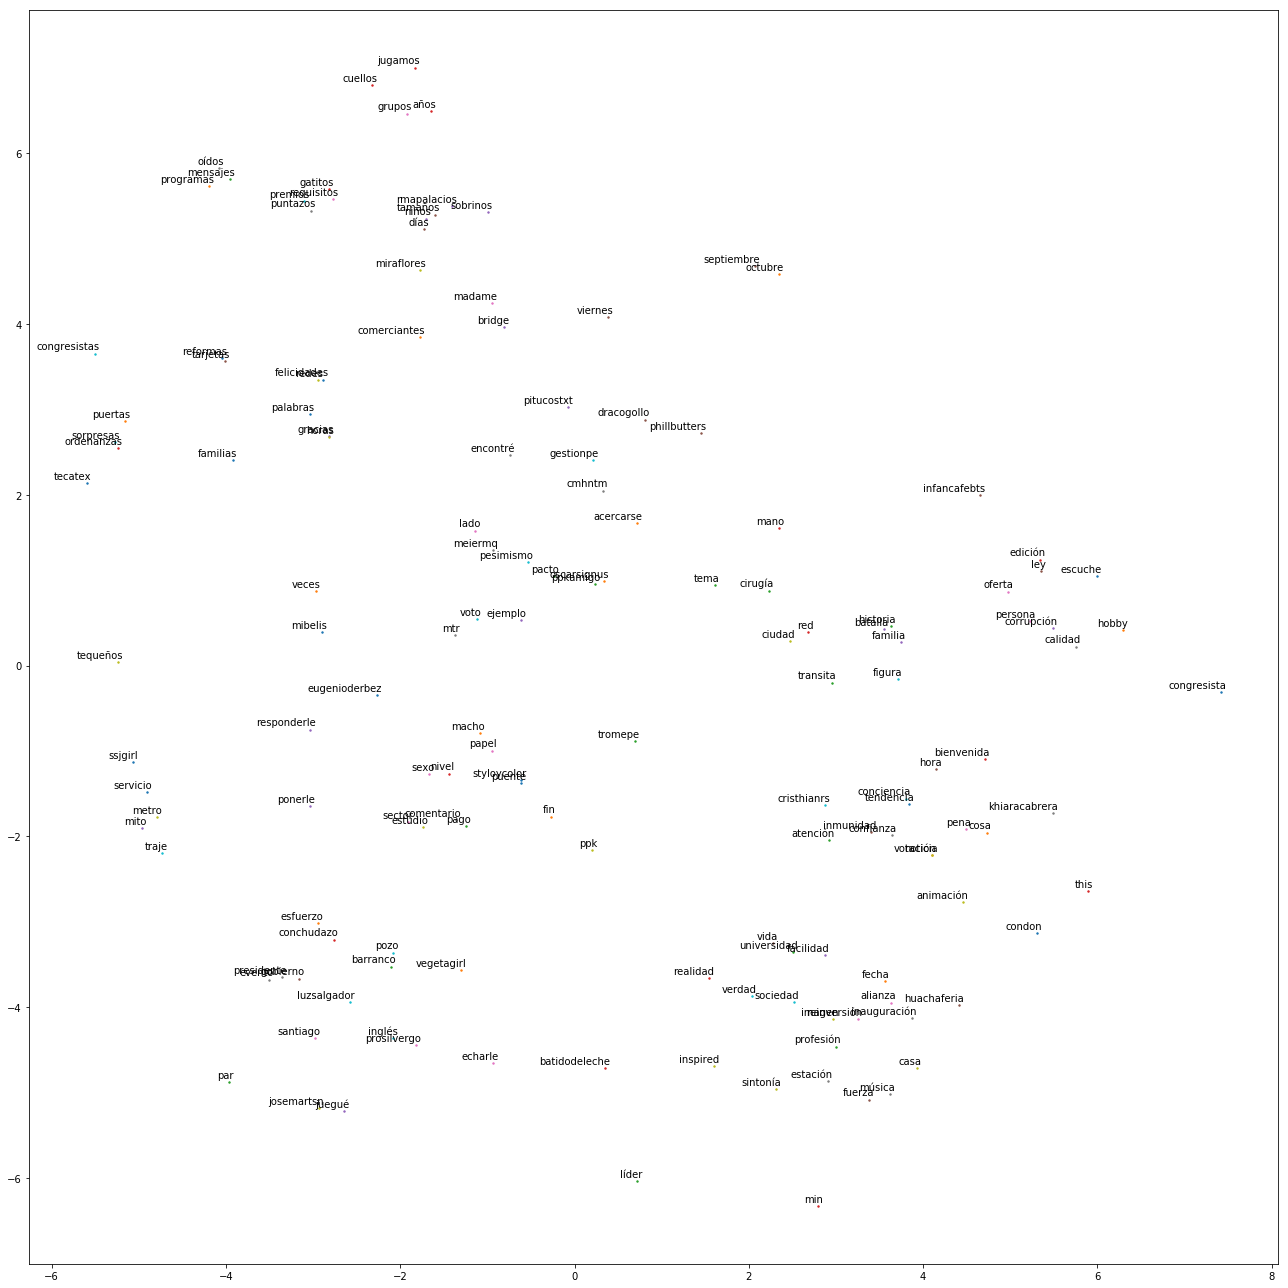

In [60]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y, s=2.0)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points',ha='right',va='bottom')
    plt.tight_layout()
    plt.savefig('lima_words_TSNE.png')
    plt.show()

# Creating the tsne plot [Warning: will take time]
tsne = TSNE(perplexity=50.0, n_components=2, init='pca', n_iter=10000)

low_dim_embedding = tsne.fit_transform(np.array([word.vector for word in nouns]))

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, [word.text for word in nouns])